# EDA: Wine Quality Prediction (0-10)

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ucimlrepo import fetch_ucirepo
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from helpers.base_imports import *

## Create new EDA

In [3]:
eda = EDA(name="wineq")
eda

Loading 'edas.csv'
Creating experiment: 'wineq'


EDA: wineq
Columns: Index(['description', 'n features', 'n samples', 'f/n ratio', 'noise', 'stats',
       'class balance', 'outliers', 'skewness', 'correlations',
       'DR potential'],
      dtype='object')
Datasets: Index([], dtype='object', name='dataset')

## Get raw dataset from remote source

In [4]:
# fetch dataset
data = fetch_ucirepo(id=186)

In [5]:
X = data.data.features
y = data.data.targets

df = pd.concat([X, y], axis=1)
disp_df(df)

In [6]:
y.columns

Index(['quality'], dtype='object')

In [7]:
X.shape, y.shape

((6497, 11), (6497, 1))

In [8]:
eda.update_param(
    "description", "Predict the quality of wine based on physicochemical tests"
)
eda.update_param("n features", X.shape[1])
eda.update_param("n samples", X.shape[0])
eda.update_param("f/n ratio", X.shape[1] / X.shape[0])

In [9]:
eda.summary_df

description n features  \
dataset                                                                 
wineq    Predict the quality of wine based on physicoch...         11   

        n samples f/n ratio noise stats class balance outliers skewness  \
dataset                                                                   
wineq        6497  0.001693   NaN   NaN           NaN      NaN      NaN   

        correlations DR potential  
dataset                            
wineq            NaN          NaN

## Noise

In [10]:
# check for missing values
X.isna().sum().sum()

np.int64(0)

In [11]:
eda.update_param("noise", "None, no missing vals")

## Stats

In [12]:
# # Calculate skewness for numeric columns only
# numeric_X = X.select_dtypes(include=[np.number])
# skewness = numeric_X.skew()

skewness = X.skew()
summary_stats = X.describe().T[["min", "max", "mean", "std"]]
summary_stats["skewness"] = skewness
summary_stats

min        max        mean        std  skewness
fixed_acidity         3.80000   15.90000    7.215307   1.296434  1.723290
volatile_acidity      0.08000    1.58000    0.339666   0.164636  1.495097
citric_acid           0.00000    1.66000    0.318633   0.145318  0.471731
residual_sugar        0.60000   65.80000    5.443235   4.757804  1.435404
chlorides             0.00900    0.61100    0.056034   0.035034  5.399828
free_sulfur_dioxide   1.00000  289.00000   30.525319  17.749400  1.220066
total_sulfur_dioxide  6.00000  440.00000  115.744574  56.521855 -0.001177
density               0.98711    1.03898    0.994697   0.002999  0.503602
pH                    2.72000    4.01000    3.218501   0.160787  0.386839
sulphates             0.22000    2.00000    0.531268   0.148806  1.797270
alcohol               8.00000   14.90000   10.491801   1.192712  0.565718

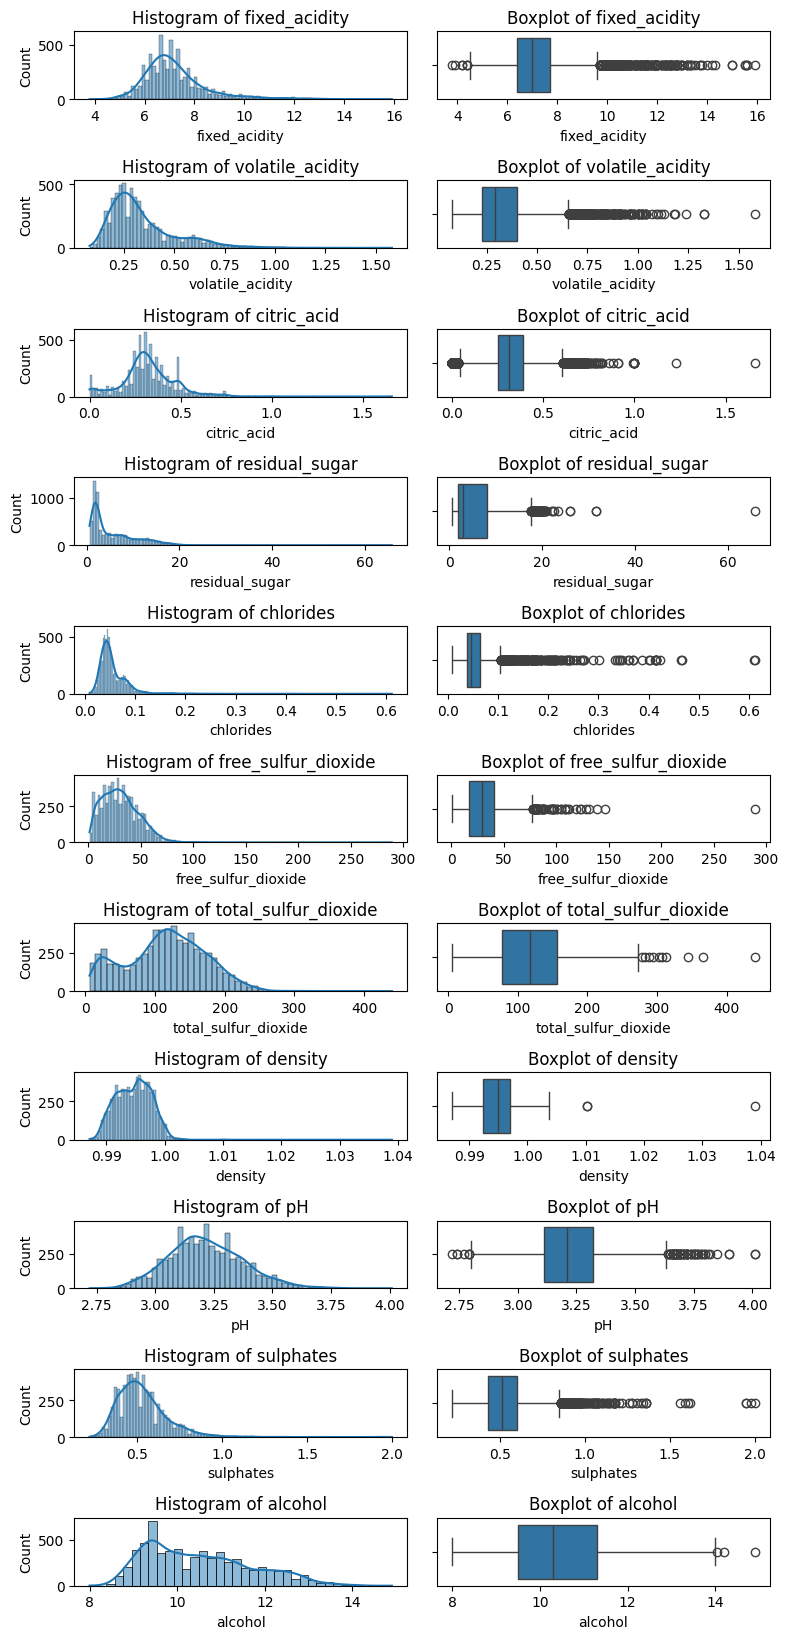

In [13]:
fig, ax = plot_feature_statistics(X, X.columns, line=False)
fig.savefig(f"{FIGS_DIR}/{eda.name}_feature-statistics.png")

In [14]:
eda.update_param("skewness", "lots of skweness in the data")
eda.update_param("stats", "strangeness")
eda.update_param("outliers", "many outliers")

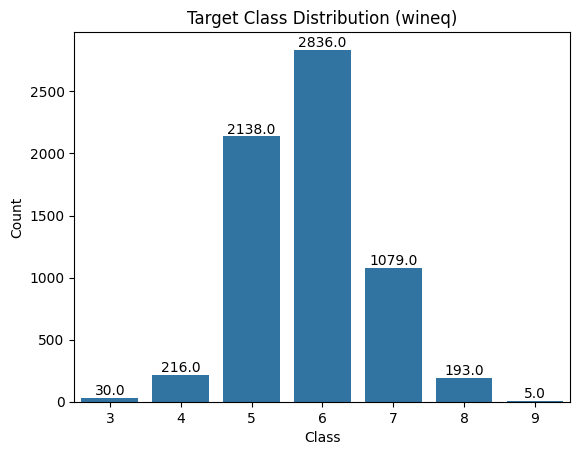

In [15]:
# class distribution of whole dataset
ax = sns.countplot(x=y.iloc[:, 0])
plt.title(f"Target Class Distribution ({eda.name})")
plt.xlabel("Class")
plt.ylabel("Count")

# Annotate each bar with the count
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height}",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.savefig(f"{FIGS_DIR}/{eda.name}_target-class-distribution.png")
plt.show()

In [16]:
eda.update_param("class balance", "~Normal")

## Feature Correlations

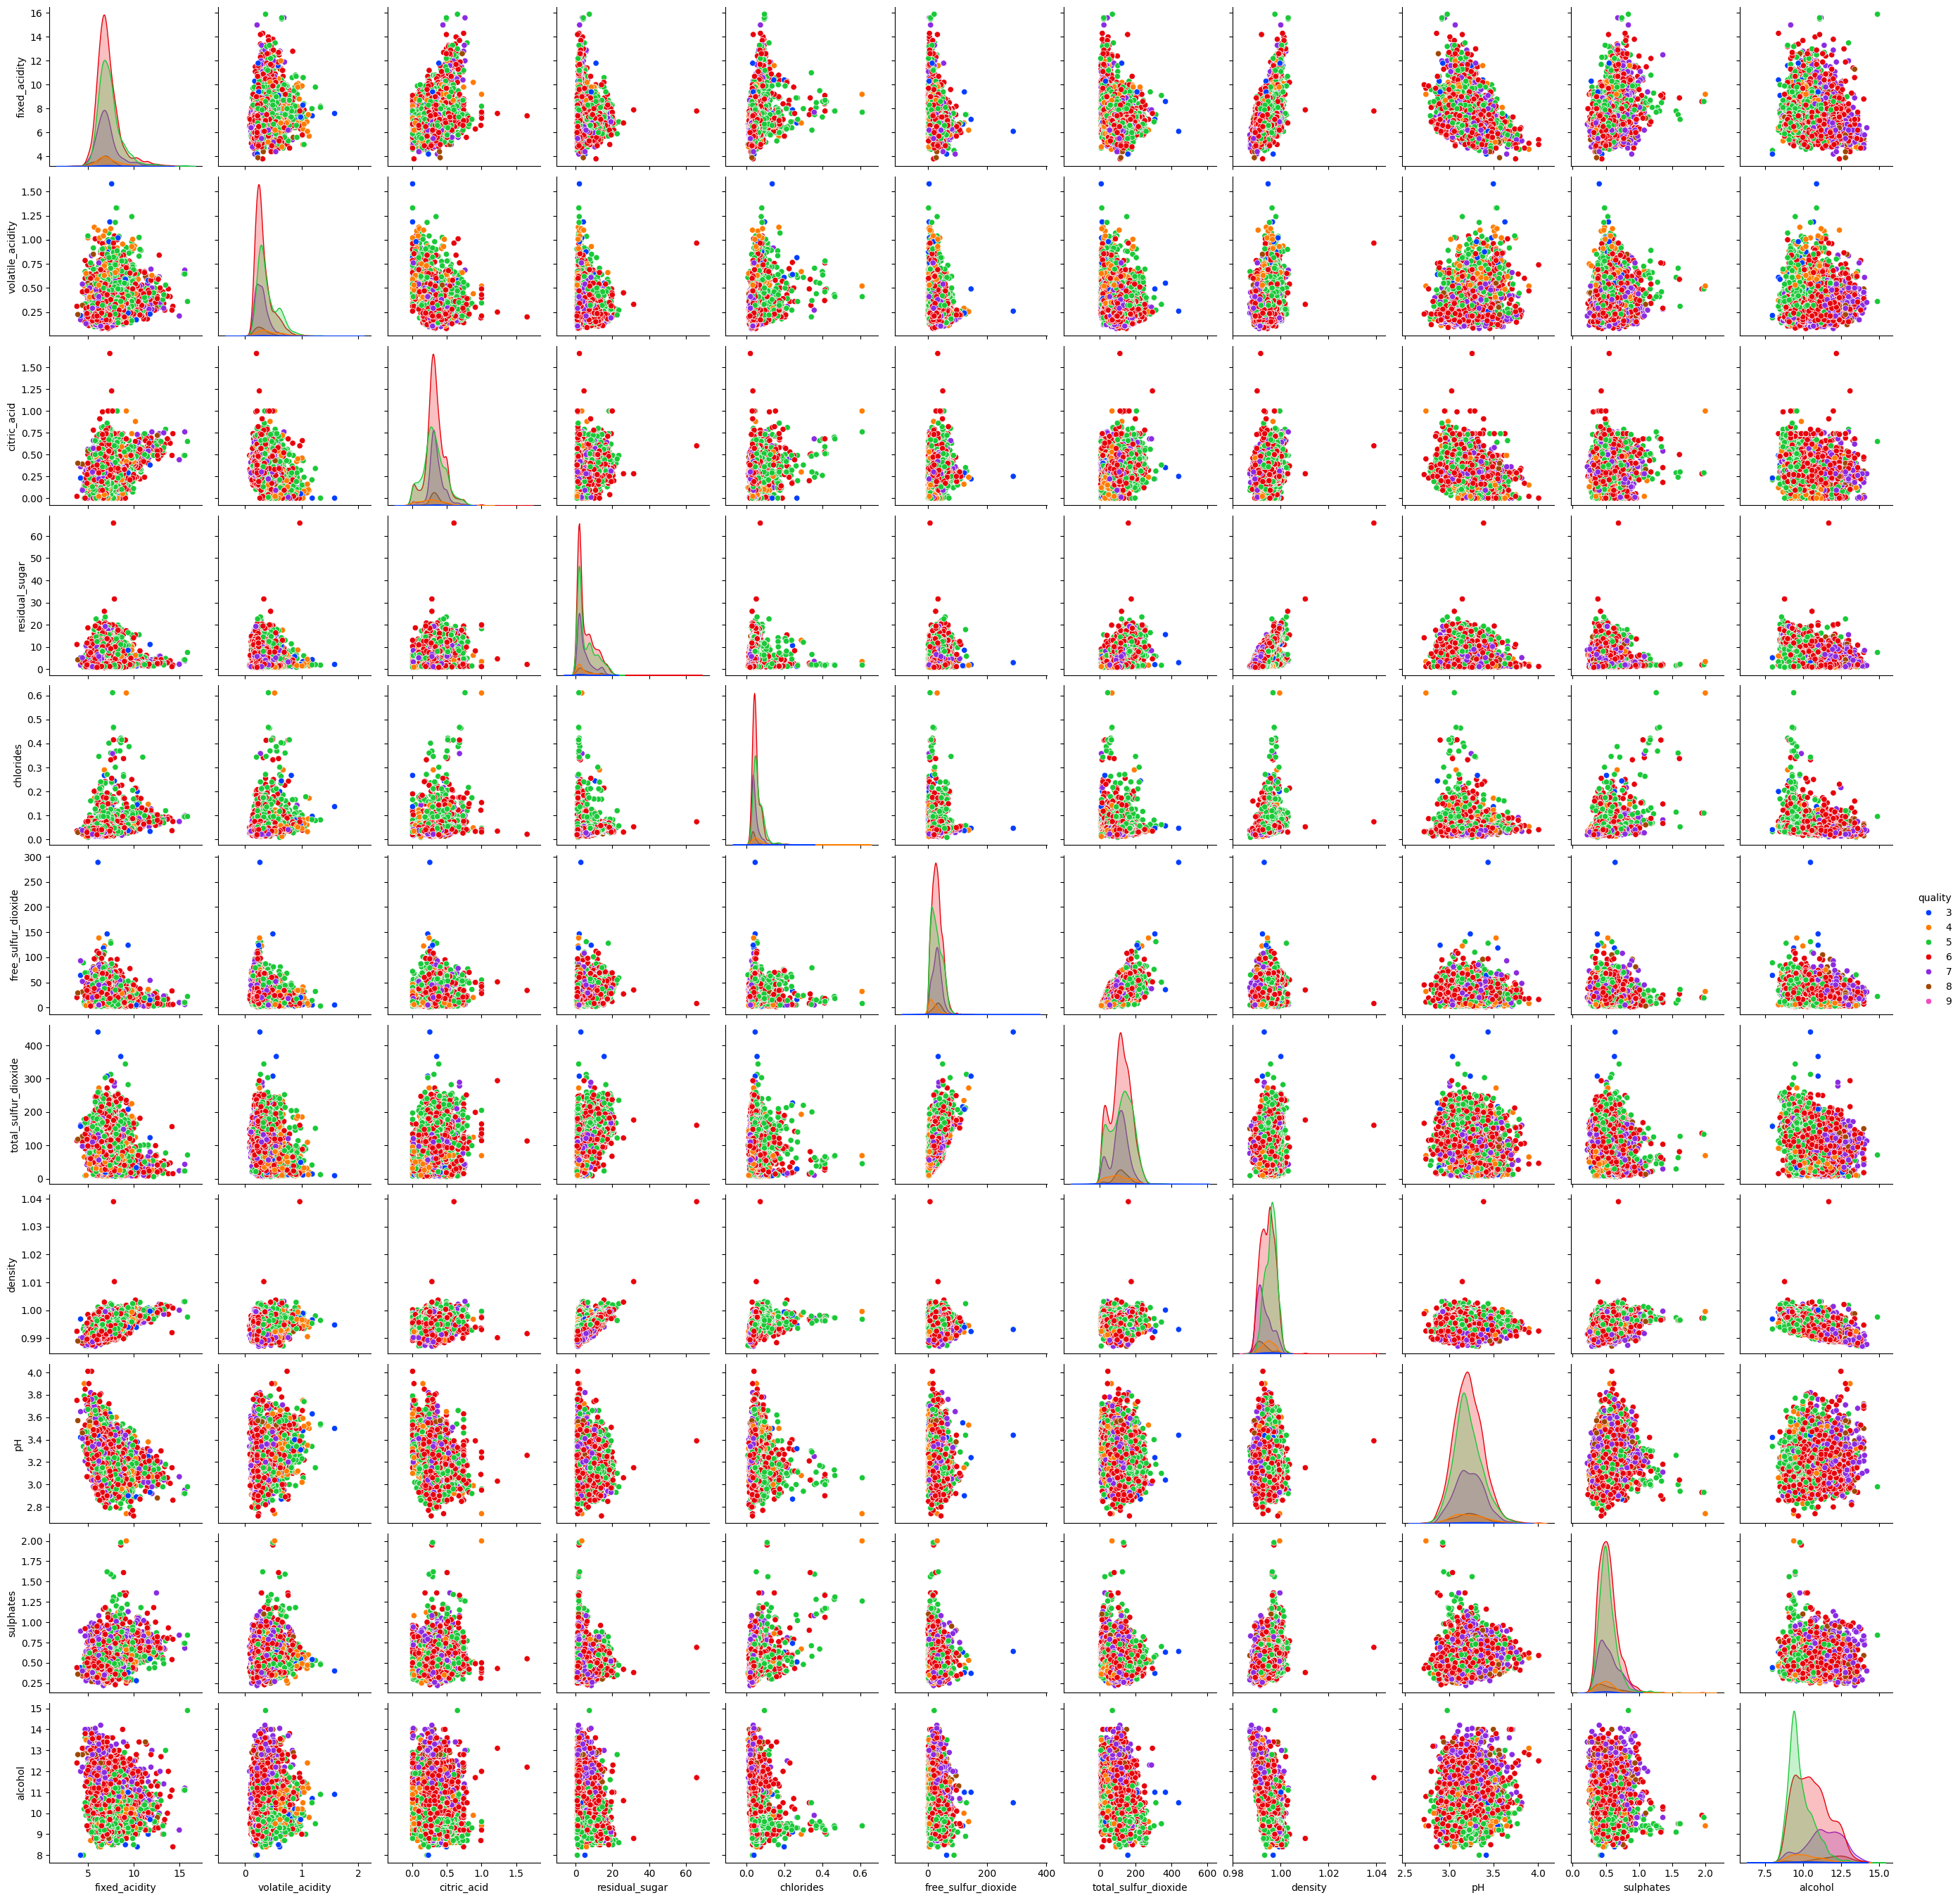

In [17]:
sns.pairplot(data=df, hue="quality", palette="bright")
plt.savefig(f"{FIGS_DIR}/{eda.name}_pairplot.png")

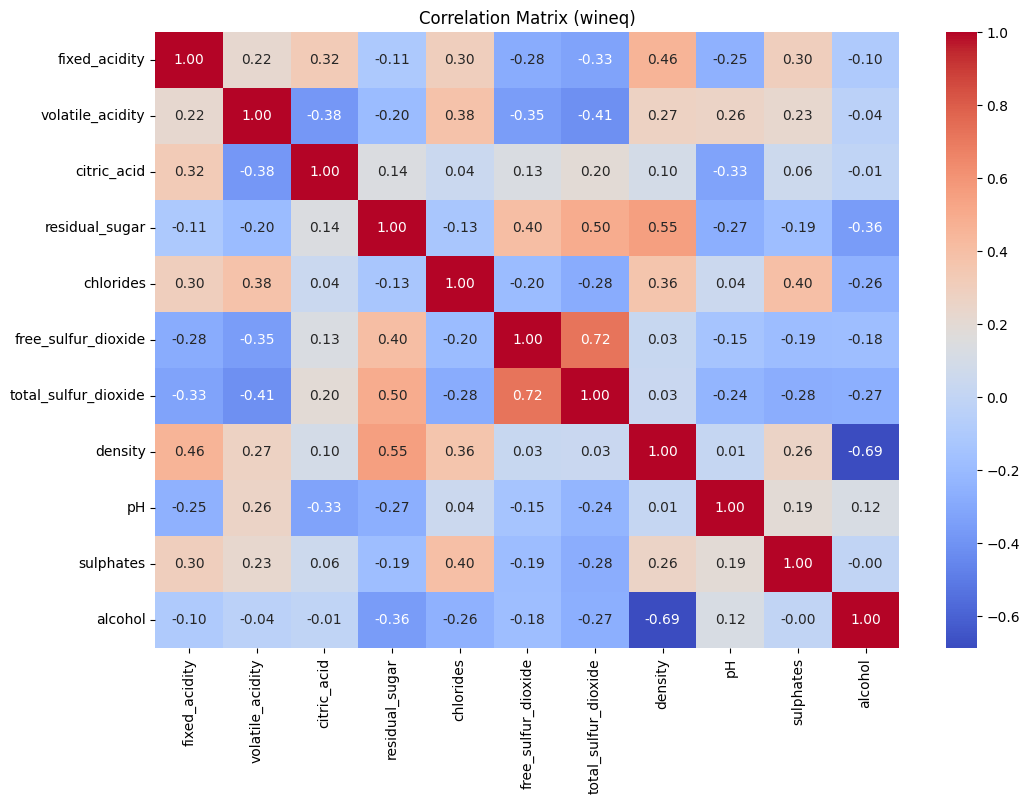

In [18]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation Matrix ({eda.name})")
plt.savefig(f"{FIGS_DIR}/{eda.name}_correlation-matrix.png")
plt.show()

In [19]:
eda.update_param("correlations", "several moderate/low correlations, 1-2 higher")

## Dimensionality Reduction Potential

In [20]:
# PCA - number of components to explain 95% variance
pca_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA()),
    ]
)
pca_pipe.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

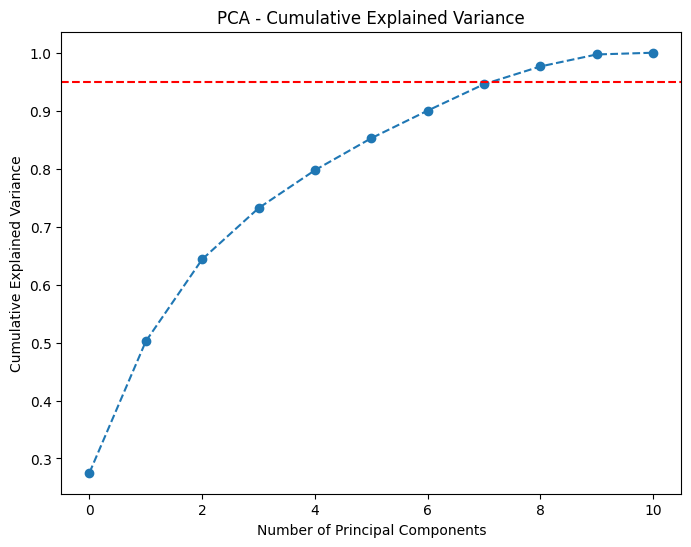

Number of original features: 11
Number of components to explain 95% of the variance: 9


In [22]:
explained_variance_ratio = pca_pipe.named_steps["pca"].explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.plot(cumulative_explained_variance, marker="o", linestyle="--")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance")
plt.axhline(y=0.95, color="r", linestyle="--")  # Threshold for 95% explained variance
plt.show()

# Number of components to explain 95% variance
num_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Number of original features: {X.shape[1]}")
print(f"Number of components to explain 95% of the variance: {num_components_95}")

In [23]:
# ICA - number of independent components
ica_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("ica", FastICA()),
    ]
)
components = ica_pipe.fit_transform(X)

# Number of independent components
num_independent_components = components.shape[1]
print(f"Number of original features: {X.shape[1]}")
print(f"Number of independent components found: {num_independent_components}")

Number of original features: 11
Number of independent components found: 11


In [24]:
eda.update_param(
    "DR potential",
    "PCA: 9 components to explain 95% variance, ICA: 11 independent components",
)

## Save EDA results

In [25]:
eda.summary_df

description n features  \
dataset                                                                 
wineq    Predict the quality of wine based on physicoch...         11   

        n samples f/n ratio                  noise        stats class balance  \
dataset                                                                         
wineq        6497  0.001693  None, no missing vals  strangeness       ~Normal   

              outliers                      skewness  \
dataset                                                
wineq    many outliers  lots of skweness in the data   

                                          correlations  \
dataset                                                  
wineq    several moderate/low correlations, 1-2 higher   

                                              DR potential  
dataset                                                     
wineq    PCA: 9 components to explain 95% variance, ICA...

In [26]:
eda.save(overwrite_existing=False)

Loading 'edas.csv'
Saving wineq to results/edas.csv


---

# Create and save a shuffled 80/20 train/test split